In [43]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, IndexToString, RFormula,VectorSlicer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
spark = SparkSession.builder.appName('logregconsult').getOrCreate()

In [3]:
# File location and type
file_location = "Telco-Customer-Churn.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

data = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .option('nanValue', ' ')\
  .option('nullValue', ' ')\
  .load(file_location)

In [4]:
imp_col = ['customerID',
 'gender',
 'SeniorCitizen',
#  'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
#  'InternetService',
#  'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
#  'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
#  'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [5]:
data = data.select(imp_col)

In [6]:
data.toPandas().to_csv('Churn_modified.csv')

In [7]:
data.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'int'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('TotalCharges', 'double'),
 ('Churn', 'string')]

In [8]:
# Get a quick overview of what we are dealing with in our dataset
data_df=data.toPandas()
data_df.head()

,customerID,gender,SeniorCitizen,Dependents,tenure,PhoneService,MultipleLines,OnlineBackup,DeviceProtection,TechSupport,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
0,7590-VHVEG,Female,0,No,1,No,No phone service,Yes,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,5575-GNVDE,Male,0,No,34,Yes,No,No,Yes,No,No,One year,No,Mailed check,1889.50,No
2,3668-QPYBK,Male,0,No,2,Yes,No,Yes,No,No,No,Month-to-month,Yes,Mailed check,108.15,Yes
3,7795-CFOCW,Male,0,No,45,No,No phone service,No,Yes,Yes,No,One year,No,Bank transfer (automatic),1840.75,No
4,9237-HQITU,Female,0,No,2,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,151.65,Yes


# EDA

In [9]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int32  
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int32  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingMovies   7043 non-null   object 
 11  Contract          7043 non-null   object 
 12  PaperlessBilling  7043 non-null   object 
 13  PaymentMethod     7043 non-null   object 
 14  TotalCharges      7032 non-null   float64
 15  Churn             7043 non-null   object 
dtypes: float64(1), int32(2), object(13)
memory

In [10]:
data_df.describe()

,SeniorCitizen,tenure,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,2283.300441
std,0.368612,24.559481,2266.771362
min,0.000000,0.000000,18.800000
25%,0.000000,9.000000,401.450000
50%,0.000000,29.000000,1397.475000
75%,0.000000,55.000000,3794.737500
max,1.000000,72.000000,8684.800000


In [11]:
data_df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
TotalCharges        11
Churn                0
dtype: int64

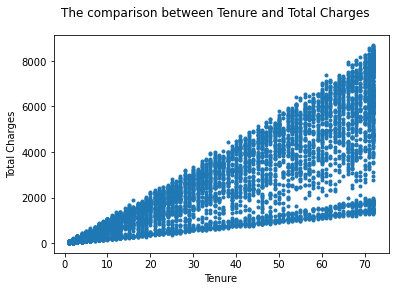

In [12]:
#Comparison between tenure and Total Charges
import matplotlib.pyplot as plt
plt.clf()
plt.plot(data_df["tenure"],data_df["TotalCharges"],".")
plt.xlabel("Tenure")
plt.ylabel("Total Charges")
plt.suptitle("The comparison between Tenure and Total Charges")
display()

<AxesSubplot:xlabel='Churn', ylabel='count'>

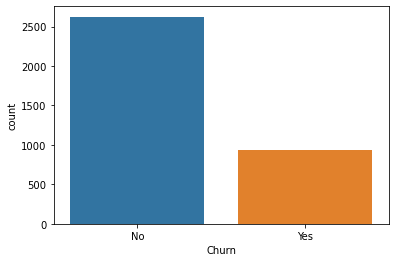

In [13]:
sns.countplot(data_df[data_df['gender']=='Male']['Churn'])

<AxesSubplot:>

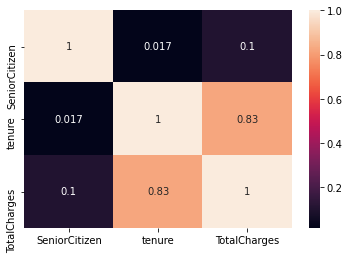

In [14]:
sns.heatmap(data_df.corr(),annot=True)

<AxesSubplot:xlabel='Churn', ylabel='count'>

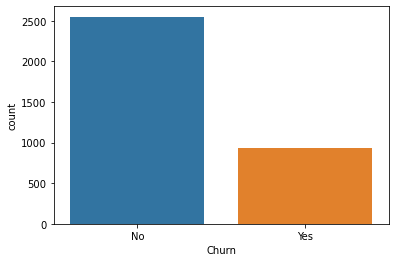

In [15]:
sns.countplot(data_df[data_df['gender']=='Female']['Churn'])

<AxesSubplot:xlabel='Churn', ylabel='count'>

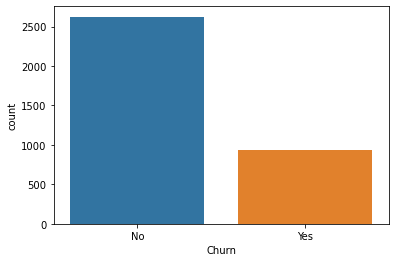

In [16]:
sns.countplot(data_df[data_df['gender']=='Male']['Churn'])

In [17]:
temp_table_churn ="churn_analysis"
data.createOrReplaceTempView(temp_table_churn)

In [18]:
#Split the data into test and train
#We can see there are 4885 rows for train data and 2158 rows for test data
(train_data,test_data) =data.randomSplit([0.7,0.3],seed=50)

print("Number of records for training data : {}".format(train_data.count()) + " rows")
print("Number of records for test data : {}".format(test_data.count()) + " rows")

Number of records for training data : 4885 rows
Number of records for test data : 2158 rows


In [19]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer,VectorAssembler

catColumns_df = ['gender',
 'SeniorCitizen',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [20]:
stages = []
for catColumn in catColumns_df:
    stringIndexer =StringIndexer(inputCol =catColumn,outputCol =catColumn + "Index")
    encoder  = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()],outputCols =[catColumn + "catVec"])
  
    stages += [stringIndexer,encoder]
stages

#imputing null values in totalcharges using Imputer
from pyspark.ml.feature import Imputer 
imputer = Imputer(inputCols =["TotalCharges"],outputCols =["Out_TotalCharges"])
stages += [imputer]

In [21]:
label_Idx = StringIndexer(inputCol="Churn",outputCol="label")
stages +=[label_Idx]
temp = label_Idx.fit(train_data).transform(train_data)

In [22]:
from pyspark.ml.feature import QuantileDiscretizer
tenure_bin =QuantileDiscretizer(numBuckets=3,inputCol="tenure",outputCol="tenure_bin")
stages +=[tenure_bin]

In [23]:
numericCols =["tenure_bin","Out_TotalCharges"] # MonthlyCharges
assembleInputs =assemblerInputs =[column + "catVec" for column in catColumns_df] +numericCols
assembler = VectorAssembler(inputCols=assembleInputs,outputCol="features")
stages +=[assembler]

In [24]:
train_data.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'int'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('TotalCharges', 'double'),
 ('Churn', 'string')]

In [25]:
pipeline =Pipeline().setStages(stages)
pipelineModel =pipeline.fit(train_data)
trainDF =pipelineModel.transform(train_data)
testDF =pipelineModel.transform(test_data)

In [26]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier()

In [27]:
model = dt.fit(trainDF)

In [28]:
pred = model.transform(testDF)
pred = pred.select(['features', 'label','probability','prediction'])
pred.show(10)

+--------------------+-----+--------------------+----------+
|            features|label|         probability|prediction|
+--------------------+-----+--------------------+----------+
|(22,[1,3,5,7,9,11...|  0.0|[0.92899140660334...|       0.0|
|(22,[1,2,7,9,11,1...|  0.0|[0.92899140660334...|       0.0|
|(22,[2,3,5,6,8,10...|  0.0|[0.28115942028985...|       1.0|
|(22,[1,2,3,4,14,1...|  0.0|[0.80352644836272...|       0.0|
|(22,[1,3,4,15,20,...|  0.0|[0.92899140660334...|       0.0|
|(22,[1,2,3,4,20,2...|  0.0|[0.92899140660334...|       0.0|
|(22,[1,2,3,5,6,8,...|  0.0|[0.71325301204819...|       0.0|
|(22,[1,2,3,5,7,8,...|  0.0|[0.47750865051903...|       1.0|
|(22,[1,3,4,15,21]...|  0.0|[0.92899140660334...|       0.0|
|(22,[0,1,3,5,15,1...|  0.0|[0.92899140660334...|       0.0|
+--------------------+-----+--------------------+----------+
only showing top 10 rows



In [29]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix

In [30]:
evaluator=MulticlassClassificationEvaluator(metricName='accuracy')
acc = evaluator.evaluate(pred)
 
print("Prediction Accuracy: ", acc)
 
y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Prediction Accuracy:  0.7896200185356812
Confusion Matrix:
[[1448  140]
 [ 314  256]]


In [37]:
featureImportances = model.featureImportances.toArray()

In [38]:
best_n_features= featureImportances.argsort()[-5:][::-1]

In [39]:
best_n_features

array([14, 10, 20, 21,  5], dtype=int64)

In [45]:
vs = VectorSlicer(inputCol='features',  outputCol='best_features',indices=best_n_features)

In [73]:
df3 = vs.transform(pred)

In [80]:
df3.columns

['features', 'label', 'probability', 'prediction', 'best_features']

In [88]:
df3 = df3.drop('best_features', 'probability', 'prediction')

In [89]:
df3.columns

['features', 'label']

In [91]:
model = dt.fit(df3)

In [92]:
pred = model.transform(df3)
pred = pred.select(['features', 'label','probability','prediction'])
pred.show(10)

+--------------------+-----+--------------------+----------+
|            features|label|         probability|prediction|
+--------------------+-----+--------------------+----------+
|(22,[1,3,5,7,9,11...|  0.0|       [0.978,0.022]|       0.0|
|(22,[1,2,7,9,11,1...|  0.0|       [0.978,0.022]|       0.0|
|(22,[2,3,5,6,8,10...|  0.0|[0.32679738562091...|       1.0|
|(22,[1,2,3,4,14,1...|  0.0|[0.82558139534883...|       0.0|
|(22,[1,3,4,15,20,...|  0.0|       [0.978,0.022]|       0.0|
|(22,[1,2,3,4,20,2...|  0.0|[0.96078431372549...|       0.0|
|(22,[1,2,3,5,6,8,...|  0.0|[0.48633879781420...|       1.0|
|(22,[1,2,3,5,7,8,...|  0.0|[0.48633879781420...|       1.0|
|(22,[1,3,4,15,21]...|  0.0|       [0.978,0.022]|       0.0|
|(22,[0,1,3,5,15,1...|  0.0|       [0.978,0.022]|       0.0|
+--------------------+-----+--------------------+----------+
only showing top 10 rows



In [94]:
evaluator=MulticlassClassificationEvaluator()
acc = evaluator.evaluate(pred)
 
print("Prediction Accuracy: ", acc)
 
y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Prediction Accuracy:  0.7937324781410678
Confusion Matrix:
[[1366  222]
 [ 223  347]]


In [81]:
featureImportances[:-2]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03628121, 0.        , 0.        , 0.        , 0.        ,
       0.13155922, 0.        , 0.        , 0.        , 0.63673836,
       0.        , 0.01464262, 0.03065906, 0.        , 0.        ])

In [82]:
# k = pred.schema['features'].metadata["ml_attr"]["attrs"]['binary']

In [85]:
# # important features
# for i,j in zip(featureImportances[:-2],k):
#     if i!=0:
#         print(i,j)

0.03628120594251123 {'idx': 5, 'name': 'MultipleLinescatVec_Yes'}
0.13155921983515728 {'idx': 10, 'name': 'TechSupportcatVec_No'}
0.6367383582899447 {'idx': 14, 'name': 'ContractcatVec_Month-to-month'}
0.01464261851680122 {'idx': 16, 'name': 'PaperlessBillingcatVec_Yes'}
0.030659059640579554 {'idx': 17, 'name': 'PaymentMethodcatVec_Electronic check'}
